In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [2]:
# learning parameters
batch_size = 256
epochs = 10
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform,
)

In [4]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('------------ GENERATOR ---------')
print(generator)
print('######################')
print('\n---------- DISCRIMINATOR ---------')
print(discriminator)
print('######################')


------------ GENERATOR ---------
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

---------- DISCRIMINATOR ---------
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss()

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator


In [9]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

def save_generator_image(image, path):
    save_image(image, path)


In [10]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [11]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [12]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [13]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    if(epoch ==0 or epoch==9 or epoch==19 or epoch==49 or epoch==99 or epoch==199):
        generated_img = generator(noise).cpu().detach()
        # make the images as grid
        generated_img = make_grid(generated_img)
        # save the generated torch tensor models to disk
        save_generator_image(generated_img, f"../outputs/gen_img{epoch}.png")
        images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(generator.state_dict(), '../outputs/generator.pth')

235it [00:14, 15.93it/s]                                                                                               
  0%|▎                                                                                 | 1/234 [00:00<00:28,  8.14it/s]

Epoch 0 of 10
Generator loss: 1.56436932, Discriminator loss: 1.10269392


235it [00:12, 18.36it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 16.82it/s]

Epoch 1 of 10
Generator loss: 2.35651064, Discriminator loss: 0.95760137


235it [00:11, 20.53it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:15, 15.18it/s]

Epoch 2 of 10
Generator loss: 1.94962859, Discriminator loss: 1.14733446


235it [00:11, 20.37it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 15.81it/s]

Epoch 3 of 10
Generator loss: 1.28002059, Discriminator loss: 1.16969550


235it [00:11, 20.01it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 15.81it/s]

Epoch 4 of 10
Generator loss: 1.66070938, Discriminator loss: 1.24882519


235it [00:11, 20.44it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:16, 14.45it/s]

Epoch 5 of 10
Generator loss: 1.72228098, Discriminator loss: 1.27270496


235it [00:11, 20.40it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:15, 14.54it/s]

Epoch 6 of 10
Generator loss: 0.98044354, Discriminator loss: 1.21778977


235it [00:11, 20.32it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 16.83it/s]

Epoch 7 of 10
Generator loss: 1.13648391, Discriminator loss: 1.15878344


235it [00:11, 20.23it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 15.81it/s]

Epoch 8 of 10
Generator loss: 2.90189075, Discriminator loss: 1.13917577


235it [00:11, 20.08it/s]                                                                                               

Epoch 9 of 10
Generator loss: 2.02596736, Discriminator loss: 1.03844595
DONE TRAINING


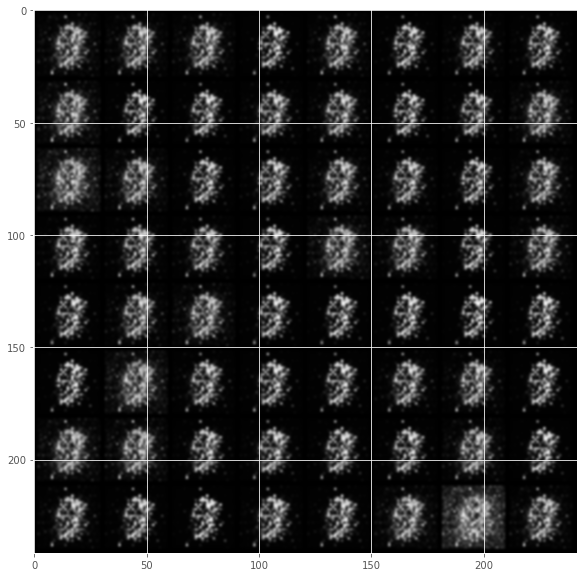

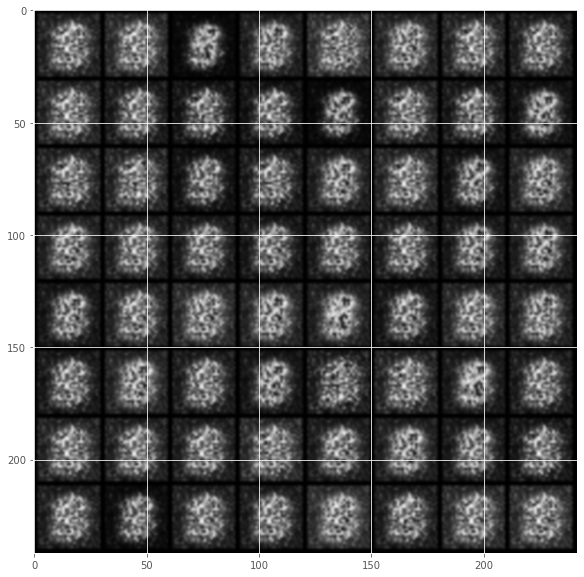

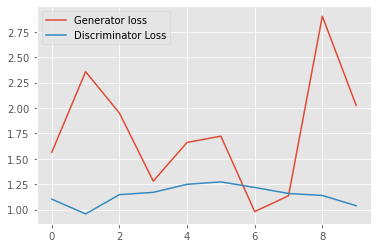

In [27]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
# imageio.mimsave('../outputs/generator_images.gif', imgs)


for img in imgs:
    plt.figure(figsize = (10,10))
    plt.imshow(img,interpolation='bicubic')
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('../outputs/loss.png')
